In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}`
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

: 

## Lab Goals:
   1. Get familiar with Graph Database Management Systems in NoSQL.
   2. Get familiar with Cypher Language.
   3. Compare between performance of MySQL database and Neo4J database

## Lab Tasks:
   1. Convert a RDBMS Schema to a Graph Schema. (0.5 Points)
   2. Perform some queries on the Graph database using Cypher Query Language. (1.5 Points)
   3. Compare MySQL to Neo4J. (3 Points)


# Introduction:
### Neo4J:
   <a href="https://neo4j.com/">Neo4J</a>  is a graph database management system developed by Neo4j, Inc. Described by its developers as a native graph storage and processing. It is the most popular graph database according to DB-Engines ranking, and the 22nd most popular database overall.
<img src="https://neo4j.com/wp-content/themes/neo4jweb/assets/images/neo4j-logo-2015.png">

## Pre-Lab:
### Installation
 1. Download the Neo4J <b>Community Server</b> from <a href="https://neo4j.com/download-center/#releases">here</a>. Follow the installation guide provided after the download for each operating system. <font color="red"> We have already downloaded the Neo4J on the Virtual Machine</font><br>
<b>To start the Neo4J server run the following command in the terminal:</b>
```
neo4j/bin/neo4j start
```

2. Install The Neo4j Python driver which is officially supported by Neo4j and connects to the database using the binary protocol. It aims to be minimal, while being idiomatic to Python. <a href="https://neo4j.com/developer/python/">here</a>:
```
pip install neo4j
```
<font color="red"> We have already installed neo4j library on this Machine</font>

In [1]:
from IPython.display import Image
# import the neo4j driver for Python
from neo4j import GraphDatabase

In [2]:
!pip install neo4j

## Task 1: Convert a RDB to a Graph DB
In this task, you are going to:
- Watch a Video explaining the advtanges of Graph Databases over RDBMS
- Convert a toy RDB into a Graph DB.
- Create the a graph of the toy database using Cyper Language

#### Watch the following video and mention some of the advantages of using Graph Databases over RDBMS

In [4]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/NO3C-CWykkY" frameborder="0" allowfullscreen></iframe>

: 

<font color = "Red"><b>Advantages of Using Neo4J over RDBMS:</b></font>
<br>1. Flexible schema, so you can easily add new types of relataionships 
<br>2. Efficient handling of complex relationships
<br>3. Reduce query complexity and improve performance
 


#### Given the following toy relational database, Convert this toy database into a Graph database using any drawing software.

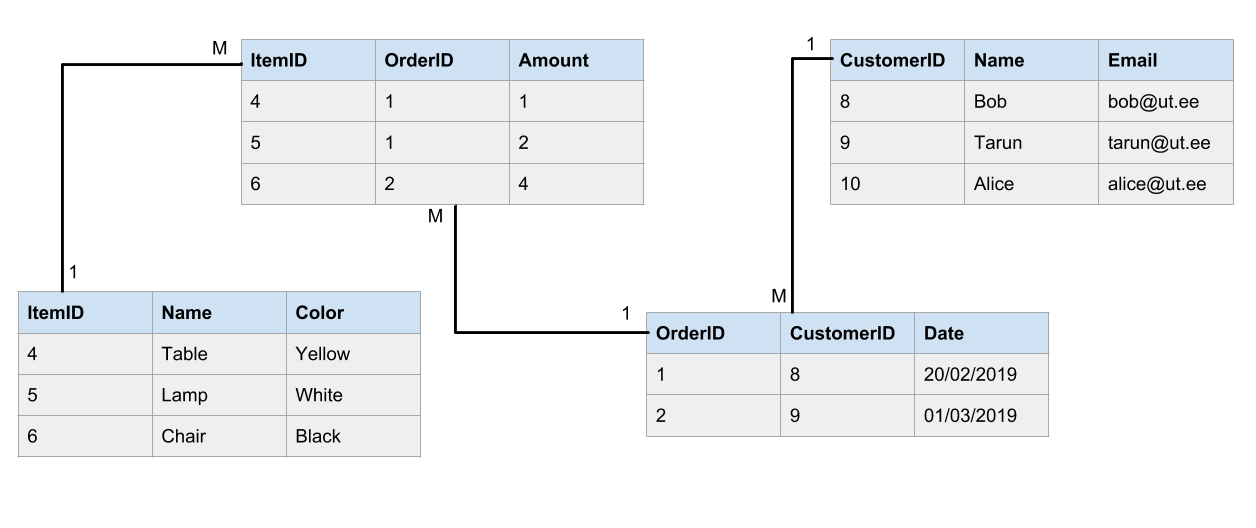

In [ ]:
Image(filename='/home/cloudera/img/week8-schema.PNG')

## Graph database representation
- Each node represents an entity *(Item, Order, or Customer)* with its properties
- Nodes are connected by relationships:
  1. **CONTAINS**: Shows what items are in each order, with the Amount property on the relationship
  2. **PLACED**: Shows which customer placed which order
---
![](https://i.imgur.com/cxwyFK1.png)

#### 2) Use Cypher Query Language to create the above Graph toy database, you have just drawed

In [ ]:
from neo4j import GraphDatabase

# Define the connection details
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

# Create a driver instance
driver = GraphDatabase.driver(URI, auth=AUTH)

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()

In [16]:
graphDB_Driver = GraphDatabase.driver(URI, auth=AUTH)
# create a graph containing the graph created above
statements = [
    # Clear existing data
    "MATCH (n) DETACH DELETE n",

    # Create Item nodes
    """CREATE (i4:Item {itemId: 4, name: 'Table', color: 'Yellow'})
       CREATE (i5:Item {itemId: 5, name: 'Lamp', color: 'White'})
       CREATE (i6:Item {itemId: 6, name: 'Chair', color: 'Black'})""",

    # Create Order nodes
    """CREATE (o1:Order {orderId: 1, date: '20/02/2019'})
       CREATE (o2:Order {orderId: 2, date: '01/03/2019'})""",

    # Create Customer nodes
    """CREATE (c8:Customer {customerId: 8, name: 'Bob', email: 'bob@ut.ee'})
       CREATE (c9:Customer {customerId: 9, name: 'Tarun', email: 'tarun@ut.ee'})
       CREATE (c10:Customer {customerId: 10, name: 'Alice', email: 'alice@ut.ee'})""",

    # Create relationships between Orders and Items with amounts
    """MATCH (o:Order {orderId: 1}), (i:Item {itemId: 4})
       CREATE (o)-[:CONTAINS {amount: 1}]->(i)""",

    """MATCH (o:Order {orderId: 1}), (i:Item {itemId: 5})
       CREATE (o)-[:CONTAINS {amount: 2}]->(i)""",

    """MATCH (o:Order {orderId: 2}), (i:Item {itemId: 6})
       CREATE (o)-[:CONTAINS {amount: 4}]->(i)""",

    # Create relationships between Customers and Orders
    """MATCH (c:Customer {customerId: 8}), (o:Order {orderId: 1})
       CREATE (c)-[:PLACED]->(o)""",

    """MATCH (c:Customer {customerId: 9}), (o:Order {orderId: 2})
       CREATE (c)-[:PLACED]->(o)"""
]
# Execute the CQL query
with graphDB_Driver.session() as graphDB_Session:
    for statement in statements:
        graphDB_Session.run(statement)

#### 3) Write a query to select all customer nodes in the graph

In [17]:
query = """
MATCH (c:Customer)
RETURN c.customerId as ID, c.name as Name, c.email as Email
"""

with graphDB_Driver.session() as graphDB_Session:
    results  = graphDB_Session.run(query)
    for record in results:
        print(record)



<Record ID=8 Name='Bob' Email='bob@ut.ee'>
<Record ID=9 Name='Tarun' Email='tarun@ut.ee'>
<Record ID=10 Name='Alice' Email='alice@ut.ee'>


#### 4) Write a query to select all relationships in the graph and print From node, to node, and relation amount

In [36]:

# Query to get all relationships with their nodes and amount
query = """
MATCH (from)-[rel]->(to) # Matches any nodes connected by any relationship
RETURN 
    CASE labels(from)[0]
        WHEN 'Customer' THEN 'Customer: ' + from.name
        WHEN 'Order' THEN 'Order: ' + toString(from.orderId)
        ELSE labels(from)[0] + ': ' + coalesce(from.name, 'N/A')
    END as FromNode,
    type(rel) as Relationship,
    CASE
        WHEN rel.amount IS NOT NULL THEN toString(rel.amount)
        ELSE '-'
    END as Amount,
    CASE labels(to)[0]
        WHEN 'Customer' THEN 'Customer: ' + to.name
        WHEN 'Order' THEN 'Order: ' + toString(to.orderId)
        WHEN 'Item' THEN 'Item: ' + to.name
        ELSE labels(to)[0] + ': ' + coalesce(to.name, 'N/A')
    END as ToNode
"""

# Execute the query and print results in a formatted way
with graphDB_Driver.session() as session:
    results = session.run(query)
    print("\nFrom Node\t\tRelationship\tAmount\tTo Node")
    print("-" * 70)
    for record in results:
        print(f"{record['FromNode']:<25} {record['Relationship']:<15} {record['Amount']:<5} {record['ToNode']}")




From Node		Relationship	Amount	To Node
----------------------------------------------------------------------
Order: 1                  CONTAINS        1     Item: Table
Order: 1                  CONTAINS        2     Item: Lamp
Order: 2                  CONTAINS        4     Item: Chair
Customer: Bob             PLACED          -     Order: 1
Customer: Tarun           PLACED          -     Order: 2


## Task 2: Perform some queries on the Graph database using Cypher Query Language.
In this task, you are going to:
- Import worldcup database
- Perform Several Quereis on the database

### worldcup.db
##### Connect to the WorldCup Database using the following Code snippet
##### Write the Cypher Query which will perform each of the following tasks

In [55]:
# Database Credentials
uri = "bolt://34.201.118.151:7687"
userName = "neo4j" #YOUR CODE HERE
password = "cleanser-purposes-petitions" #YOUR CODE HERE

graphDB_Driver = GraphDatabase.driver(uri, auth=(userName, password))
try:
    with graphDB_Driver.session() as session:
        result = session.run("RETURN 1")
        print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")
finally:
    graphDB_Driver.close()

Connection successful!


In [58]:
uri = "bolt://34.201.118.151:7687"
userName = "neo4j" #YOUR CODE HERE
password = "cleanser-purposes-petitions" #YOUR CODE HERE

graphDB_Driver = GraphDatabase.driver(uri, auth=(userName, password))

#### The schema of the DB:

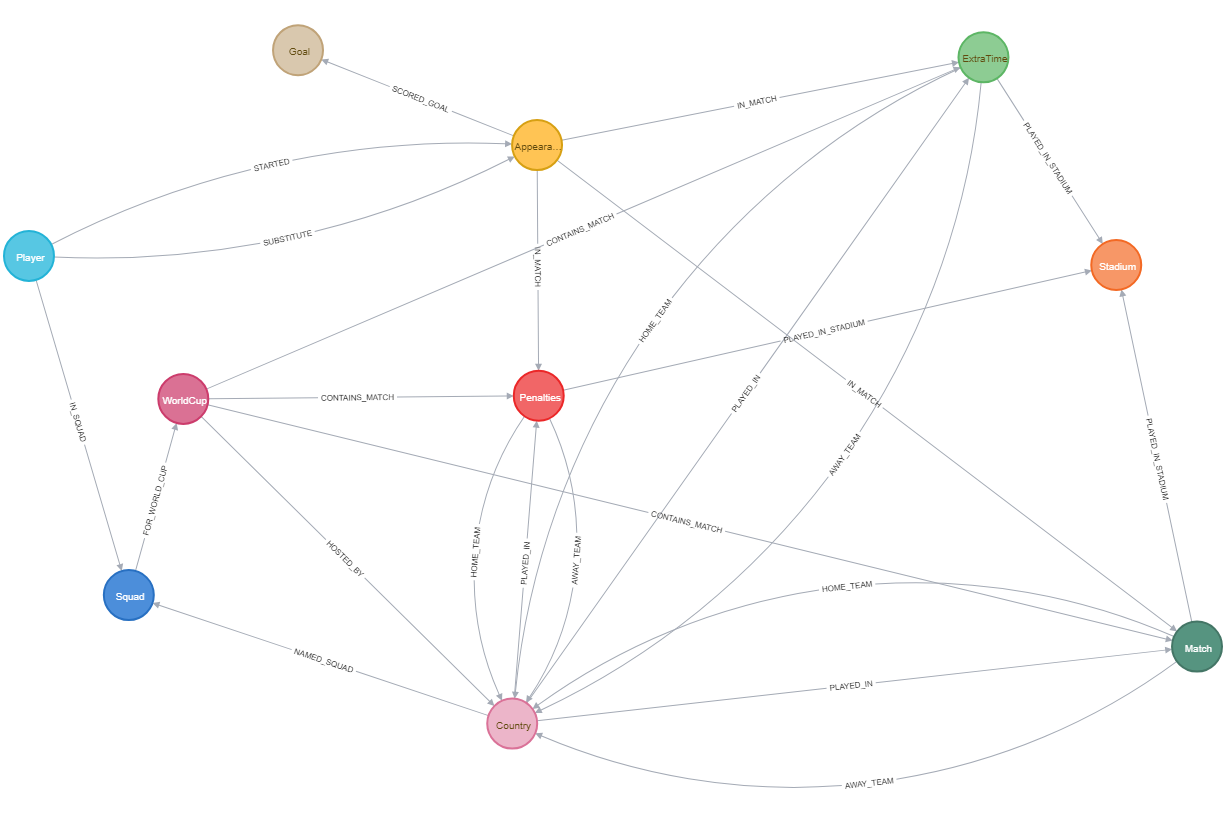

In [ ]:
Image(filename='/home/cloudera/img/week8-graph.png')

#### Another simplified Schema with labels of nodes:

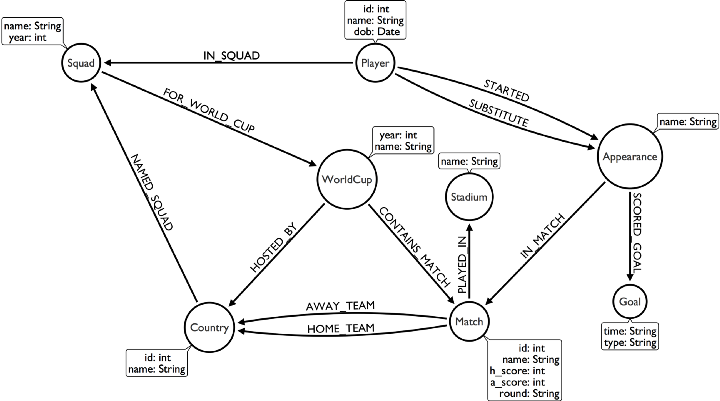

In [ ]:
Image(filename='/home/cloudera/img/week8-graph2.png')

you can access the following link to see the quries and their associated outputs.
[link](https://github.com/hassaangamal/world-cup-graph/tree/main)

## Task 3: Compare MySQL to Neo4J
In this task, you are going to:
 - Convert a MySQL Database to a Graph Database
 - Perform Some SQL queries on the Relational Database
 - Perform the same queries on the Graph Database
 - Compare the Time performance on each database

#### 1. Download the MySQL Database provided <a href = "https://github.com/datacharmer/test_db"> HERE </a>
#### 2. Follow the installation guide in the above URL
##### The DB schema can be found in the provided URL and it is shown also below:

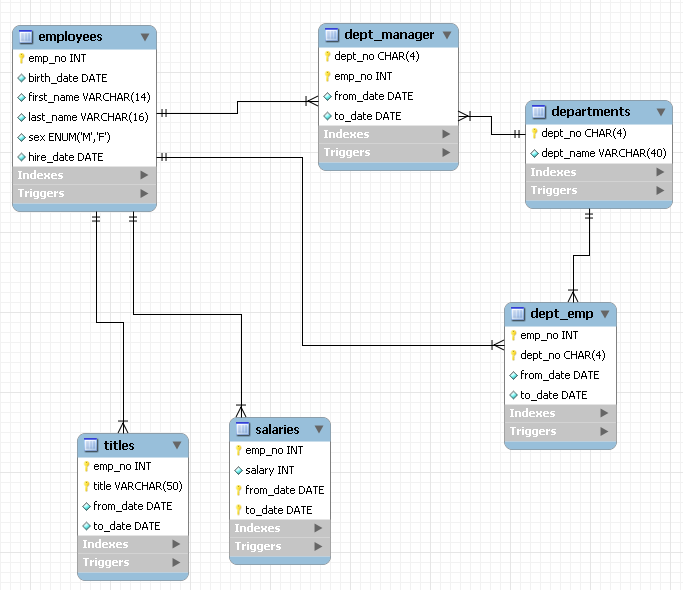

In [ ]:
Image(filename='/home/cloudera/img/week8-schemadb.png')

#### 3. Host The database locally using MySQL and Phpmyadmin on local apache server.
##### We have already installed all the needed tools (apache, phpmyadmin, and mysql)
##### To start the apache server run the following command

In [98]:
!pip install mysql-connector-python

   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
    --------------------------------------- 0.3/16.1 MB ? eta -:--:--
   -- ------------------------------------- 1.0/16.1 MB 4.2 MB/s eta 0:00:04
   ---- ----------------------------------- 1.8/16.1 MB 3.9 MB/s eta 0:00:04
   ------ --------------------------------- 2.6/16.1 MB 3.7 MB/s eta 0:00:04
   -------- ------------------------------- 3.4/16.1 MB 3.8 MB/s eta 0:00:04
   ---------- ----------------------------- 4.2/16.1 MB 3.8 MB/s eta 0:00:04
   ------------- -------------------------- 5.2/16.1 MB 3.8 MB/s eta 0:00:03
   --------------- ------------------------ 6.0/16.1 MB 3.8 MB/s eta 0:00:03
   ---------------- ----------------------- 6.8/16.1 MB 3.8 MB/s eta 0:00:03
   ------------------ --------------------- 7.3/16.1 MB 3.8 MB/s eta 0:00:03
   -------------------- ------------------- 8.4/16.1 MB 3.8 MB/s eta 0:00:03
   ---------------------- ----------------- 9.2/16.1 MB 3.8 MB/s eta 0:00:02
   ----------

In [6]:
import mysql.connector

def connect_to_db():
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Hassan540@",
        database="employees"
    )
    return connection

In [4]:
def do_query(query):
    connection = connect_to_db()
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    
    for row in results:
        print(row)
    
    cursor.close()
    connection.close()

In [ ]:
from neo4j import GraphDatabase

# Define the connection details
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

def execute_query(driver, query, return_results=False):
    with driver.session() as session:
        try:
            result = session.run(query)
            records = list(result)
            print("Query executed successfully")
            return records
            
        except Exception as e:
            print(f"Error executing query: {str(e)}")
            return None

Connected to Neo4j successfully
Query executed successfully
Time taken to execute the query: 0.06 seconds
[<Record Department='Customer Service' EmployeeCount=23580>, <Record Department='Marketing' EmployeeCount=20211>]


##### What is the highest Salary for an employee working in the Research department, and Finance department?


In [10]:
import time

query = """
        SELECT d.dept_name, MAX(s.salary) AS highest_salary
        FROM salaries s
        JOIN dept_emp de ON s.emp_no = de.emp_no
        JOIN departments d ON de.dept_no = d.dept_no
        WHERE d.dept_name IN ('Research', 'Finance')
        GROUP BY d.dept_name;
        """ 
start_time = time.time()
do_query(query)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")

('Finance', 142395)
('Research', 130211)
Time taken to execute the query: 0.43 seconds


In [ ]:
from neo4j import GraphDatabase

with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Connected to Neo4j successfully")

    query = """
    MATCH (e:Employee)-[:WORKS_IN]->(d:Department)
    WHERE d.dept_name IN ['Research', 'Finance']
    RETURN d.dept_name AS Department, MAX(e.salary) AS HighestSalary;
    """
    start_time = time.time()
    record = execute_query(driver, query, return_results=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")
    print(record)

Connected to Neo4j successfully
Query executed successfully
Time taken to execute the query: 0.06 seconds
[<Record Department='Finance' HighestSalary='99984'>, <Record Department='Research' HighestSalary='99975'>]


##### How many employees in the marketing department, and customer service department?

In [13]:
query = """
        SELECT d.dept_name, COUNT(de.emp_no) AS employee_count
        FROM dept_emp de
        JOIN departments d ON de.dept_no = d.dept_no
        WHERE d.dept_name IN ('Marketing', 'Customer Service')
        GROUP BY d.dept_name;
        """
start_time = time.time()
do_query(query)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")

('Customer Service', 23580)
('Marketing', 20211)
Time taken to execute the query: 0.19 seconds


In [ ]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Connected to Neo4j successfully")
    
    query = """
    MATCH (e:Employee)-[:WORKS_IN]->(d:Department)
    WHERE d.dept_name IN ['Marketing', 'Customer Service']
    RETURN d.dept_name AS Department, COUNT(e) AS EmployeeCount;
    """
    start_time = time.time()
    record = execute_query(driver, query, return_results=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")
    print(record)   

Connected to Neo4j successfully
Query executed successfully
Time taken to execute the query: 0.06 seconds
[<Record Department='Customer Service' EmployeeCount=23580>, <Record Department='Marketing' EmployeeCount=20211>]


##### What is the average Salaries of the department Managers?

In [21]:
query = """
        SELECT 
            d.dept_name,
            AVG(s.salary) as avg_manager_salary
        FROM dept_manager dm
        JOIN departments d ON dm.dept_no = d.dept_no
        JOIN salaries s ON dm.emp_no = s.emp_no
        GROUP BY d.dept_name;
        """
start_time = time.time()
do_query(query)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")

('Marketing', Decimal('88371.6857'))
('Finance', Decimal('70815.8889'))
('Human Resources', Decimal('58286.0556'))
('Production', Decimal('56233.4000'))
('Development', Decimal('59658.1176'))
('Quality Management', Decimal('67130.9355'))
('Sales', Decimal('85738.7647'))
('Research', Decimal('77535.1818'))
('Customer Service', Decimal('54959.6724'))
Time taken to execute the query: 0.27 seconds


In [24]:
with GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()
    print("Connected to Neo4j successfully")
    
    query = """
    MATCH (e:Employee)-[:MANAGES]->(d:Department)
    RETURN AVG(e.salary) AS AverageManagerSalary;
    """
    start_time = time.time()
    record = execute_query(driver, query, return_results=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken to execute the query: {elapsed_time:.2f} seconds")
    print(record)   

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownRelationshipTypeWarning} {category: UNRECOGNIZED} {title: The provided relationship type is not in the database.} {description: One of the relationship types in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing relationship type is: MANAGES)} {position: line: 2, column: 26, offset: 26} for query: '\n    MATCH (e:Employee)-[:MANAGES]->(d:Department)\n    RETURN AVG(e.salary) AS AverageManagerSalary;\n    '


Connected to Neo4j successfully
Query executed successfully
Time taken to execute the query: 0.00 seconds
[<Record AverageManagerSalary=None>]


Unfortunately, the data has been ingested into the Neo4j database, but there are issues with some of the relationships. Despite my efforts to resolve these problems, I was unable to fix them completely **(wallahy 7awlet)**.

#### Query Execution Times: MySQL vs Neo4j

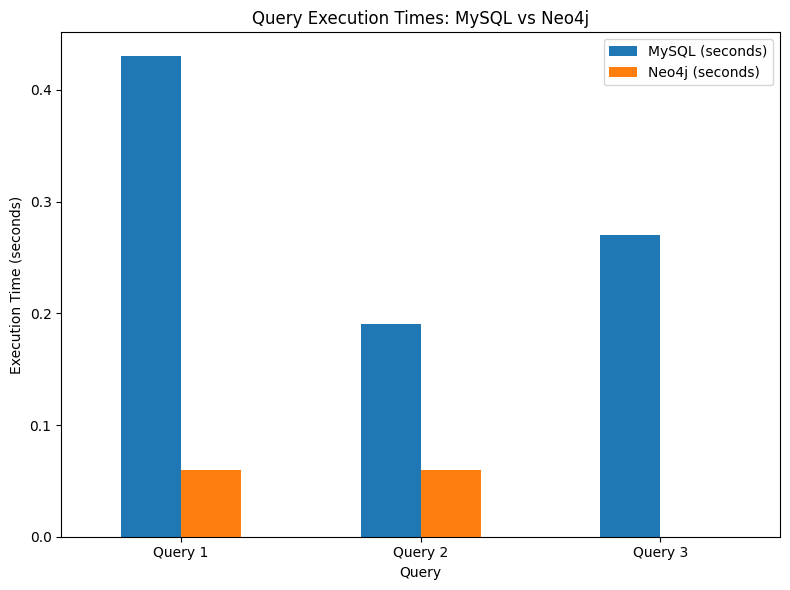

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Query": ["Query 1", "Query 2", "Query 3"],
    "MySQL (seconds)": [0.43, 0.19, 0.27],
    "Neo4j (seconds)": [0.06, 0.06, None]
}

df = pd.DataFrame(data)

df["Neo4j (seconds)"] = df["Neo4j (seconds)"].fillna(0)

# Plot the data
fig, ax = plt.subplots()
df.plot(
    x="Query",
    kind="bar",
    ax=ax,
    figsize=(8, 6),
    title="Query Execution Times: MySQL vs Neo4j",
    ylabel="Execution Time (seconds)",
    xlabel="Query",
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar chart effectively shows that neo4j execution times are more fast than mysql execution times

#### Write Cypher Code suitable for converting the MySQL Database into a Graph Database


In [ ]:
# I write the code in neo4j ui 
    """
    Create Employees
    
    LOAD CSV FROM 'file:///employees.csv' AS row
    WITH 
    row[0] AS emp_no, 
    row[1] AS birth_date, 
    row[2] AS first_name, 
    row[3] AS last_name, 
    row[4] AS sex, 
    row[5] AS hire_date
    CREATE (:Employee {emp_no: emp_no, birth_date: birth_date, first_name: first_name, last_name: last_name, sex: sex, hire_date: hire_date});

    Create Departments
    LOAD CSV FROM 'file:///departments.csv' AS row
    WITH row[0] AS dept_no, row[1] AS dept_name
    CREATE (:Department {dept_no: dept_no, dept_name: dept_name});


    Create Titles and Relationships
    LOAD CSV FROM 'file:///titles.csv' AS row
    WITH row[0] AS emp_no, row[1] AS title, row[2] AS from_date, row[3] AS to_date
    MERGE (e:Employee {emp_no: emp_no})
    MERGE (t:Title {title: title})
    MERGE (e)-[:HAS_TITLE {from_date: from_date, to_date: to_date}]->(t);

    Create Salaries
    LOAD CSV WITH HEADERS FROM 'file:///salaries.csv' AS row
    MERGE (e:Employee {emp_no: row[0]})
    SET e.salary = row[1];
    
    Create Department-Employee Relationships
    LOAD CSV WITH HEADERS FROM 'file:///dept_emp.csv' AS row
    MERGE (e:Employee {emp_no: row[0]})
    MERGE (d:Department {dept_no: row[1]})
    MERGE (e)-[:WORKS_IN {from_date: row[2], to_date: row[3]}]->(d);
    
    Create Manager Relationships
    LOAD CSV WITH HEADERS FROM 'file:///dept_manager.csv' AS row
    MERGE (e:Employee {emp_no: row[0]})
    MERGE (d:Department {dept_no: row[1]})
    MERGE (e)-[:MANAGES {from_date: row[2], to_date: row[3]}]->(d);

    """